## Introducción 


Una serie de tiempo es una sucesión de datos ordenados cronológicamente espaciados en intervalos iguales o desiguales. El proceso de pronóstico consiste en predecir el valor futuro de una serie de tiempo, ya sea modelando la serie únicamente en función de su comportamiento pasado (autoregresivo) o utilizando otras variables externas.

![](https://www.cienciadedatos.net/images/forecasting_multi-step_en.gif)

Skforecast , una biblioteca simple que contiene las clases y funciones necesarias para adaptar cualquier modelo de regresión Scikit-learn a problemas de pronóstico.

## Aprendizaje automático para pronósticos 


Para aplicar modelos de aprendizaje automático a problemas de pronóstico, la serie de tiempo debe transformarse en una matriz en la que cada valor esté relacionado con la ventana de tiempo (retrasos) que lo precede.

En un contexto de serie de tiempo, un retraso con respecto a un paso de tiempo t
 se define como los valores de la serie en pasos de tiempo anteriores. Por ejemplo, lag 1 es el valor en el paso de tiempo $t-1$

 ![](https://www.cienciadedatos.net/images/transform_timeseries.gif)
 

Este tipo de transformación también permite incluir variables adicionales.

![](https://www.cienciadedatos.net/images/matrix_transformation_with_exog_variable.png)

Una vez que los datos se han reorganizado en la nueva forma, se puede entrenar cualquier modelo de regresión para predecir el siguiente valor (paso) de la serie. Durante el entrenamiento del modelo, cada fila se considera una instancia de datos separada, donde los valores en los retrasos $1, 2, ... p$  se consideran predictores de la cantidad objetivo de la serie de tiempo en el paso de tiempo $p+ 1$
 .

## Pronóstico recursivo de varios pasos 


Dado que el valor $t_{n-1}$  se requiere para predecir $t_n$  y $t_{n-1}$ se desconoce, se aplica un proceso recursivo en el que, cada nueva predicción, se basa en la anterior. Este proceso se conoce como pronóstico recursivo o pronóstico recursivo de varios pasos y se puede generar fácilmente con las clases `ForecasterAutoreg` y `ForecasterAutoregCustom`

![](https://www.cienciadedatos.net/images/diagram-recursive-mutistep-forecasting.png)

Diagrama recursivo del proceso de predicción de varios pasos para predecir 3 pasos hacia el futuro utilizando los últimos 4 retrasos de la serie como predictores.

## Pronóstico directo de varios pasos 
El pronóstico directo de varios pasos consiste en entrenar un modelo diferente para cada paso del horizonte de pronóstico. Por ejemplo, para predecir los siguientes 5 valores de una serie temporal, se entrenan 5 modelos diferentes, uno para cada paso. Como resultado, las predicciones son independientes entre sí

![](https://www.cienciadedatos.net/images/diagram-direct-multi-step-forecasting.png)

Diagrama directo del proceso de predicción de varios pasos para predecir 3 pasos hacia el futuro utilizando los últimos 4 retrasos de la serie como predictores.

La principal complejidad de este enfoque es generar las matrices de entrenamiento correctas para cada modelo. La ForecasterAutoregDirectclase de la biblioteca skforecast automatiza este proceso. También es importante tener en cuenta que esta estrategia tiene un mayor costo computacional ya que requiere el tren de múltiples modelos. El siguiente diagrama muestra el proceso para un caso en el que se dispone de la variable de respuesta y dos variables exógenas.

![](https://www.cienciadedatos.net/images/diagram_skforecast_multioutput.png)

## Pronóstico autorregresivo recursivo 


Se dispone de una serie temporal con el gasto mensual (millones de dólares) en corticoides que tuvo el sistema sanitario australiano entre 1991 y 2008. Se pretende crear un modelo autorregresivo capaz de predecir los futuros gastos mensuales.

Bibliotecas 


Las bibliotecas utilizadas en este documento son:

In [ ]:
#%pip install skforecast==0.12.1

  Using cached skforecast-0.12.1-py3-none-any.whl.metadata (22 kB)
   ---------------------------------------- 0.0/560.6 kB ? eta -:--:--
   ---------------------------------------- 560.6/560.6 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: optuna
    Found existing installation: optuna 4.1.0
    Uninstalling optuna-4.1.0:
      Successfully uninstalled optuna-4.1.0
  Attempting uninstall: skforecast
    Found existing installation: skforecast 0.14.0
    Uninstalling skforecast-0.14.0:
      Successfully uninstalled skforecast-0.14.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
import skforecast
print(skforecast.__version__)


0.12.1


In [5]:
import skforecast
import os
print(os.listdir(skforecast.__path__[0]))

['datasets', 'exceptions', 'ForecasterAutoreg', 'ForecasterAutoregCustom', 'ForecasterAutoregDirect', 'ForecasterAutoregMultiSeries', 'ForecasterAutoregMultiSeriesCustom', 'ForecasterAutoregMultiVariate', 'ForecasterBase', 'ForecasterBaseline', 'ForecasterRnn', 'ForecasterSarimax', 'model_selection', 'model_selection_multiseries', 'model_selection_sarimax', 'plot', 'preprocessing', 'Sarimax', 'utils', '__init__.py', '__pycache__']


In [6]:

# ==============================================================================
import numpy as np
import pandas as pd


# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline


# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings

# warnings.filterwarnings('ignore')

In [8]:
data=pd.read_excel("https://github.com/Wilsonsr/Series-de-Tiempo/raw/main/Data/data.xlsx")
data=data.drop(columns='Unnamed: 0')
data

,fecha,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199
...,...,...,...,...
190,2008-02-01,0.761822,1.515840,1.786373
191,2008-03-01,0.649435,1.506258,1.694264
192,2008-04-01,0.827887,1.505253,1.627135
193,2008-05-01,0.816255,1.491464,1.555068


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fecha   195 non-null    object 
 1   y       195 non-null    float64
 2   exog_1  195 non-null    float64
 3   exog_2  195 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.2+ KB


In [10]:
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


In [11]:
print(f'Número de Filas con valores nulos: {data.isnull().any(axis=1).mean()}')


Número de Filas con valores nulos: 0.0


In [12]:
# Verifique que un índice temporal esté completo 
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()


True

In [13]:
#Train_test split# ==============================================================================
steps = 24
data_train = data[:-steps]
data_test  = data[-steps:]


In [14]:

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates : 1992-04-01 00:00:00 --- 2006-06-01 00:00:00  (n=171)
Test dates  : 2006-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=24)


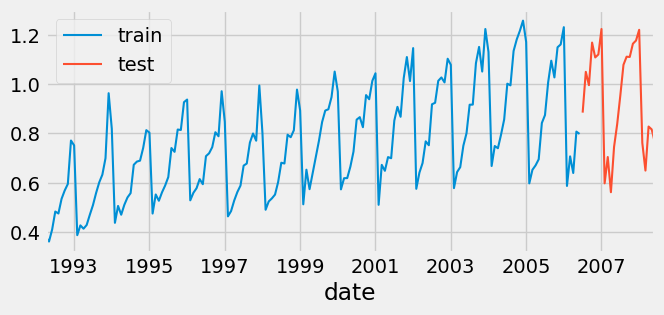

In [15]:

fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

## Pronosticador Autoreg 


Con la ForecasterAutoregcla se se crea y entrena un modelo a partir de un RandomForestRegressorregresor con una ventana de tiempo de 6 rezagos. Esto significa que el modelo utiliza los 6 meses anteriores como predictores.

In [16]:
forecaster = ForecasterAutoreg(
                regressor = DecisionTreeRegressor(random_state=123,),
                lags      = 12
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2006-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 123, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2025-03-28 22:24:39 
Last fit date: 2025-03-28 22:24:39 
Skforecast version: 0.12.1 
Python version: 3.12.4 
Forecaster id: None 

## Predicciones 


Una vez que se entrena el modelo, se predicen los datos de prueba (36 meses en el futuro).

In [17]:
steps = 24
predictions = forecaster.predict(steps=steps)
predictions

2006-07-01    0.856803
2006-08-01    1.006497
2006-09-01    0.916887
2006-10-01    1.012313
2006-11-01    1.181011
2006-12-01    1.013024
2007-01-01    1.257238
2007-02-01    0.594189
2007-03-01    0.652590
2007-04-01    0.639641
2007-05-01    0.851926
2007-06-01    0.695248
2007-07-01    0.851926
2007-08-01    0.924368
2007-09-01    0.916887
2007-10-01    1.026976
2007-11-01    1.109590
2007-12-01    1.012313
2008-01-01    1.102776
2008-02-01    0.575584
2008-03-01    0.641165
2008-04-01    0.679862
2008-05-01    0.851926
2008-06-01    0.752096
Freq: MS, Name: pred, dtype: float64

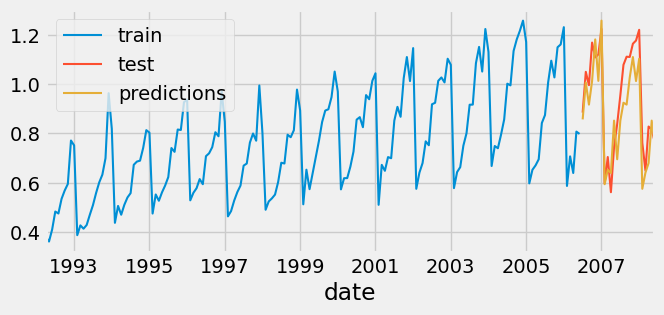

In [18]:
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

## Error de predicción en el conjunto Test


Se cuantifica el error que comete el modelo en sus predicciones. En este caso, la métrica utilizada es el error cuadrático medio (mse).

In [19]:
np.sqrt(0.07)

0.2645751311064591

# MSE

In [20]:
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.011330086376068048


## RMSE

In [21]:
error_rmse = root_mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (Rmse): {error_rmse}")

Test error (Rmse): 0.10644287846572005


In [22]:
np.sqrt(0.004038053499192591)

0.06354568041332621

## MAPE

In [23]:
error_MAPE = mean_absolute_percentage_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (MAPE): {error_MAPE}")

Test error (MAPE): 0.09499028057402938


## Ajuste de hiperparámetros 


El entrenamiento `ForecasterAutoreg` usa una ventana de tiempo de retraso de 6 y un modelo Random Forest con los hiperparámetros predeterminados. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. Para identificar la mejor combinación de retrasos e hiperparámetros, la biblioteca Skforecast proporciona la grid_search_forecasterfunción. Compara los resultados obtenidos con cada configuración del modelo.

In [24]:
#Hyperparameter Grid search
# ==============================================================================
steps = 24
forecaster = ForecasterAutoreg(
                regressor = DecisionTreeRegressor(random_state=123),
                lags      = 12 
             )

# Lags used as predictors
lags_grid = [6,12, 18,24]

# Regressor's hiperparametros
param_grid = {'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 10}
  Backtesting metric: 0.10659607436105868



In [25]:
# Grid Search results
# ==============================================================================
results_grid

,lags,lags_label,params,mean_absolute_percentage_error,max_depth
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.106596,10
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'max_depth': 10},0.107161,10
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 3},0.107947,3
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'max_depth': 3},0.109905,3
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'max_depth': 5},0.111030,5
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 5},0.120101,5
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.120719,10
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 5},0.122572,5
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 3},0.122793,3
2,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]",{'max_depth': 10},0.212763,10


## Modelo final 


Finalmente, `ForecasterAutoreg` se entrena a con la configuración óptima encontrada por validación. 

In [26]:
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 12
             )

forecaster.fit(y=data_train['y'])

In [27]:
pronostico = forecaster.predict(steps=steps)

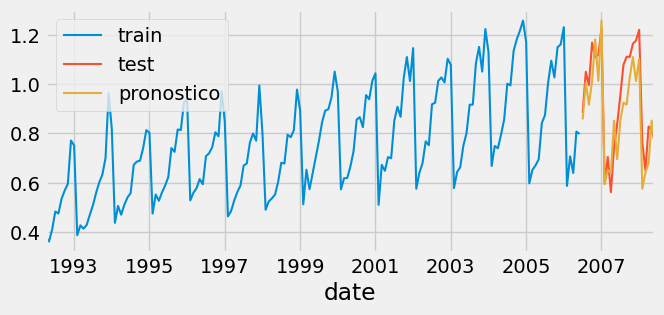

In [28]:
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='pronostico')
ax.legend();

In [29]:
#error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.011330086376068048


In [30]:

# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')


data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

fig, ax = plt.subplots(figsize=(7, 3))
data['y'].plot(ax=ax, label='y')
data['exog_1'].plot(ax=ax, label='variable exogena')
ax.legend();

HTTPError: HTTP Error 404: Not Found

In [ ]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=data_train['y'], exog=data_train['exog_1'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-05-06 06:20:32 
Last fit date: 2023-05-06 06:20:32 
Skforecast version: 0.7.0 
Python version: 3.9.16 
Fo

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

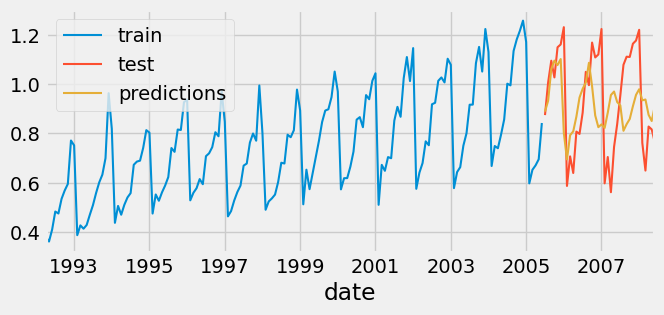

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.03989087922533575


In [ ]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['y'],
                    exog        = data_train['exog_1'],
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    steps       = steps,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    return_best = True,
                    verbose     = False
               )

Number of models compared: 27.
loop lags_grid: 100%|███████████████████████████████████████| 3/3 [02:08<00:00, 42.71s/it]
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 0.007172428407773492



In [ ]:
# Grid Search results
# ==============================================================================
results_grid.head()

,lags,params,mean_squared_error,max_depth,n_estimators
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 50}",0.007172,10,50
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 100}",0.007176,10,100
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 500}",0.007535,10,500
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 500}",0.007960,5,500
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 100}",0.008168,5,100


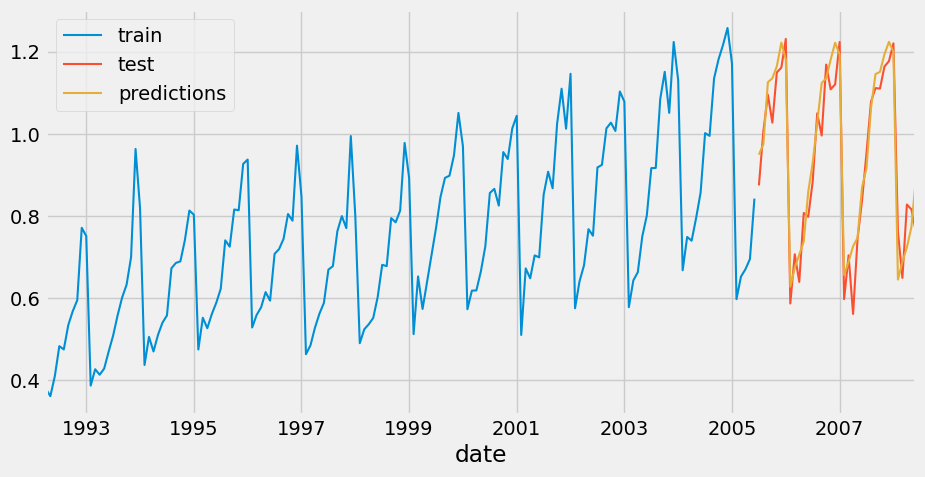

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.0044949967759907675


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b01f3fd-002a-43ad-8b2f-83f22b9a4ee6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>